# Importing relevant libraries

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

# Setting up the data folder

In [2]:
from google.colab import drive
drive.mount('/content/drive')

os.chdir("/content/drive/My Drive/Project_2/")
os.getcwd()

Mounted at /content/drive


'/content/drive/My Drive/Project_2'

# Reading the data file

In [3]:
df = pd.read_csv("/content/drive/My Drive/Project_2/CSE All-Share Historical Data (1).csv")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,02/26/2024,"10,612.17","10,655.35","10,693.85","10,607.77",NaN,-0.41%
1,02/22/2024,"10,655.35","10,649.30","10,680.25","10,642.62",NaN,0.06%
2,02/21/2024,"10,649.30","10,638.06","10,664.63","10,626.52",NaN,0.11%
3,02/20/2024,"10,638.06","10,643.05","10,662.46","10,620.05",36.80M,-0.05%
4,02/19/2024,"10,643.05","10,586.11","10,652.01","10,585.12",91.58M,0.54%


# Preprocessing the data

In [4]:
#Converting 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

# Removing non-numeric characters and convert numerical columns to float
for col in df.columns[1:]:
    df[col] = df[col].str.replace(r'[^\d.]', '', regex=True).astype(float)


# Drop rows with missing values
df.dropna(inplace=True)

#Normalizing the numerical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df.drop(columns='Date'))

# Creating time series data with three-day windows
lookback = 3
generator = TimeseriesGenerator(scaled_data, scaled_data, length=lookback, batch_size=1)



## Splitting the data into training and testing, maintaining an 80-20% split ratio.


In [5]:

train_size = int(len(scaled_data) * 0.8)
test_size = len(scaled_data) - train_size
train, test = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [6]:
#for LSTM model
def create_sequences(data, lookback):
    X, y = [], []
    for i in range(len(data) - lookback):
        X.append(data[i:(i + lookback), 0])
        y.append(data[i + lookback, 0])
    return np.array(X), np.array(y)

#for training and testing data
X_train, y_train = create_sequences(train, lookback)
X_test, y_test = create_sequences(test, lookback)

#Reshaping the data for LSTM input
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

#LSTM – RNN model Creation

In [7]:
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(1))

 # LSTM – RNN model Training


In [8]:
model.compile(loss='mean_squared_error', optimizer='adam')
hist = model.fit(X_train, y_train, epochs=10, batch_size=1, verbose=1)

Epoch 1/10
887/887 [==============================] - 7s 4ms/step - loss: 0.0060
Epoch 2/10
887/887 [==============================] - 5s 5ms/step - loss: 0.0015
Epoch 3/10
887/887 [==============================] - 4s 5ms/step - loss: 0.0012
Epoch 4/10
887/887 [==============================] - 5s 5ms/step - loss: 0.0011
Epoch 5/10
887/887 [==============================] - 5s 6ms/step - loss: 0.0012
Epoch 6/10
887/887 [==============================] - 3s 3ms/step - loss: 0.0010
Epoch 7/10
887/887 [==============================] - 3s 3ms/step - loss: 9.7475e-04
Epoch 8/10
887/887 [==============================] - 3s 4ms/step - loss: 0.0010
Epoch 9/10
887/887 [==============================] - 6s 6ms/step - loss: 8.4581e-04
Epoch 10/10
887/887 [==============================] - 4s 4ms/step - loss: 9.1512e-04


#Predicting stock prices

In [9]:
Y_predictions = model.predict(X_test)
# Reshape Y_predictions to match the shape of X_train
Y_predictions = Y_predictions.reshape(-1, 1)


7/7 [==============================] - 2s 5ms/step


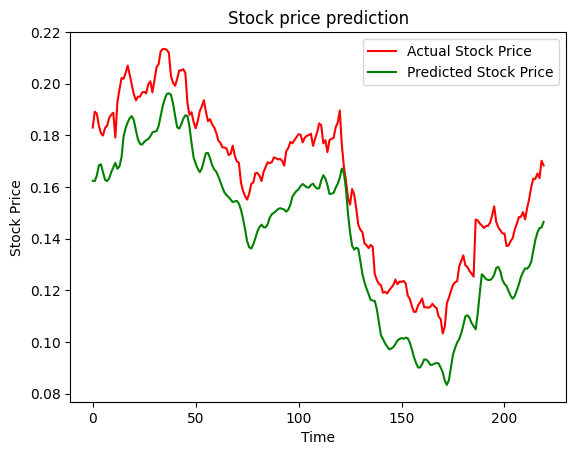

In [10]:
plt.plot(y_test, color = 'red', label = 'Actual Stock Price')
plt.plot(Y_predictions, color = 'green', label = 'Predicted Stock Price')
plt.title('Stock price prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# The performance of the model by computing the Root Mean Squared Error(RMSE) value

In [11]:
rmse = np.sqrt(np.mean(((Y_predictions - y_test) ** 2)))
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 0.04660887062100741
